# Surface Code
Notebook for playing around and building a surface code using Qiskit. We begin by following [An introduction to the surface code, Andrew N. Cleland](https://scipost.org/SciPostPhysLectNotes.49/pdf). 

### Simple Examples
Let's first create the quantum circuit for one surface code cycle for a measure-Z qubit, forcing data qubits into an eigenstate of (stabilizes) $Z_0Z_1Z_2Z_3$ and for a measure-X qubit, which stabilizes $X_0X_1X_2X_3$ (i.e. figure 20 from the paper).

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile
from qiskit.quantum_info import Statevector
import numpy as np

#Declare backend we will use throughout
simulator = Aer.get_backend('aer_simulator')

# Create a Quantum Register with 5 qubits (4 data qubits and 1 ancilla qubit for stabilzer +measurement)
qreg = QuantumRegister(5, 'q')

# Create a Classical Register with 1 bit
creg = ClassicalRegister(1, 'c')

# Create an Z measure Quantum Circuit 
Zcircuit = QuantumCircuit(qreg, creg)

# Entangle the data qubits with the ancilla qubit
for i in range(1,5):
    Zcircuit.cx(qreg[i], qreg[0])  # Apply CX gate between data qubit and ancilla

# Measure the ancilla qubit and store the result in the classical bit
Zcircuit.measure(qreg[0], creg[0])

Zcircuit.draw()

┌───┐┌───┐┌───┐┌───┐┌─┐
q_0: ┤ X ├┤ X ├┤ X ├┤ X ├┤M├
     └─┬─┘└─┬─┘└─┬─┘└─┬─┘└╥┘
q_1: ──■────┼────┼────┼───╫─
            │    │    │   ║ 
q_2: ───────■────┼────┼───╫─
                 │    │   ║ 
q_3: ────────────■────┼───╫─
                      │   ║ 
q_4: ─────────────────■───╫─
                          ║ 
c: 1/═════════════════════╩═
                          0

Once we make projective measurement of the measure qubits e.g. for $Z$ measure qubit, the state will
be $$Z_{0123}|\psi\rangle$$ ($Z_{0123} = \pm 1$). This state is the quiescent state. When we extend to a full array, starting with the very first complete measurement cycle when starting up a surface code, the $Z$ measure and $X$ measure take whatever initial state the data qubits are in, and project from that state a complex entangled state $|\psi\rangle$ that is a simultaneous eigenstate of all the measurements across the array. Once selected, in the absence of errors, the same state $|\psi\rangle$ will be maintained by each
subsequent cycle of the sequence, with each measure qubit yielding the same measurement
outcome as it measured in the previous cycle (due to the stabilizer measurements commuting). Let's illustrate this by first just considering the $Z$ measure circuit.

In [2]:
num_cycles = 5

# Create a Quantum Register with 5 qubits (4 data qubits and 1 ancilla qubit for stabilizer + measurement)
qreg = QuantumRegister(5, 'q')
# Create a Classical Register with a bit for each cycle
creg = ClassicalRegister(num_cycles, 'c')
# Create a Quantum Circuit for each cycle
Zcircuit = QuantumCircuit(qreg, creg)

# Create an arbitrary initial state for data qubits (we choose 1/sqrt{2}(|0000> + |0111>) for illustration)
Zcircuit.h(1)
Zcircuit.cx(1,2)
Zcircuit.cx(2,3)

for cycle in range(num_cycles):
    # Reset the ancilla qubit to the |0> state
    Zcircuit.reset(qreg[0])

    # Entangle the data qubits with the ancilla qubit
    for i in range(1, 5):
        Zcircuit.cx(qreg[i], qreg[0])

    # Seeing the state of our initial circuit for visualization
    if cycle == 0:
        state_simulator = Aer.get_backend('statevector_simulator')
        job = execute(Zcircuit, state_simulator)
        state_vector = job.result().get_statevector()

    # Measure the ancilla qubit and store the result in the classical register
    Zcircuit.measure(qreg[0], creg[cycle])

# Execute the circuit
job = execute(Zcircuit, simulator, shots=1)
result = job.result().get_counts()

# Print pre-measurement state
print("Pre Measurement State: ", np.asarray(state_vector).real, "\n")

# Extract and print the measurement result for each cycle
measurement_results = list(result.keys())[0]  # Assuming a single shot, so only one key
for cycle in range(num_cycles):
    # In Qiskit, the bits are in reverse order
    cycle_measurement = measurement_results[-1-cycle]
    print(f"Cycle {cycle} Measurement: {cycle_measurement}")


Pre Measurement State:  [0.70710678 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.70710678 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ] 

Cycle 0 Measurement: 1
Cycle 1 Measurement: 1
Cycle 2 Measurement: 1
Cycle 3 Measurement: 1
Cycle 4 Measurement: 1


Here we can see an illustration of this. The initial state is $$\frac{1}{\sqrt{2}} (|0000\rangle + |0111\rangle)\otimes |0\rangle$$. Then, after the cycle (pre-measurement), the ancilla becomes entangled with the data qubits and the state is $1/\sqrt{2} (|00000\rangle + |01111\rangle)$. Now we can clearly see that a measurement of 0 or 1 of the ancilla will causes the state to collapse to a +1 ($|0000\rangle$) or -1 ($|0111\rangle$)  eigenstate of the $Z_0 Z_1 Z_2 Z_3$ stabilizer respectively. This collpased state is the quiescent state, and we can see from the other ancilla qubit measurements that this state remains throughout the following cycles (provided there's no errors!). We can now see this is the case for the $X$-measure qubit too.

In [3]:
num_cycles = 3

# Create a Quantum Register with 5 qubits (4 data qubits and 1 ancilla qubit for stabilizer + measurement)
qreg = QuantumRegister(5, 'q')
# Create a Classical Register with a bit for each cycle
creg = ClassicalRegister(num_cycles, 'c')
# Create a Quantum Circuit for each cycle
Xcircuit = QuantumCircuit(qreg, creg)

# Initialize data qubits to |0000>
# No additional gates needed as qubits are initialized to |0> by default

for cycle in range(num_cycles):
    # Reset the ancilla qubit to the |0> state
    Xcircuit.reset(qreg[0])

    #Change ancilla basis
    Xcircuit.h(qreg[0])

    # Entangle the data qubits with the ancilla qubit (now ancilla is the control)
    for i in range(1, 5):
        Xcircuit.cx(qreg[0], qreg[i])


    #Change the ancilla basis
    Xcircuit.h(qreg[0])
    
    # Seeing the state of our initial circuit for visualization
    if cycle == 0:
        state_simulator = Aer.get_backend('statevector_simulator')
        job = execute(Xcircuit, state_simulator)
        state_vector = job.result().get_statevector()

    # Measure the ancilla qubit and store the result in the classical register
    Xcircuit.measure(qreg[0], creg[cycle])

# Execute the circuit
simulator = Aer.get_backend('aer_simulator')
job = execute(Xcircuit, simulator, shots=1)
result = job.result().get_counts()

# Print pre-measurement state
print("Pre Measurement State: ", np.asarray(state_vector).real, "\n")

# Extract and print the measurement result for each cycle
measurement_results = list(result.keys())[0]  # Assuming a single shot, so only one key
for cycle in range(num_cycles):
    # In Qiskit, the bits are in reverse order
    cycle_measurement = measurement_results[-1-cycle]
    print(f"Cycle {cycle} Measurement: {cycle_measurement}")


Pre Measurement State:  [ 0.5  0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.5 -0.5] 

Cycle 0 Measurement: 0
Cycle 1 Measurement: 0
Cycle 2 Measurement: 0


We also see the same thing here. The initial state of the data qubits is $|0000\rangle$, then the entanglement with the ancilla projects the state to 
$$
\large |\psi\rangle = \frac{1}{2}\left((|0000\rangle + |1111\rangle) \otimes |0\rangle + (|0000\rangle - |1111\rangle) \otimes |1\rangle)\right).
$$
So then measurement of the $X$-type ancilla leaves the system in one of two possible eigenstates of $X_1X_2X_3X_4$, with the ancilla measurement indicating which: 0 (1) for +1 (-1) eigenvalue.

### 7 qubit Error Detection Surface Code
The smallest possible surface code (working from [Repeated Quantum Error Detection in a Surface Code](https://arxiv.org/pdf/1912.09410.pdf)) has 7 qubits, 4 data qubits ($D_1, D_2, D_3, D_4$), 2 $Z$ ancillas ($Z_1Z_2$) and 1 $X$ ancilla ($X_1$).

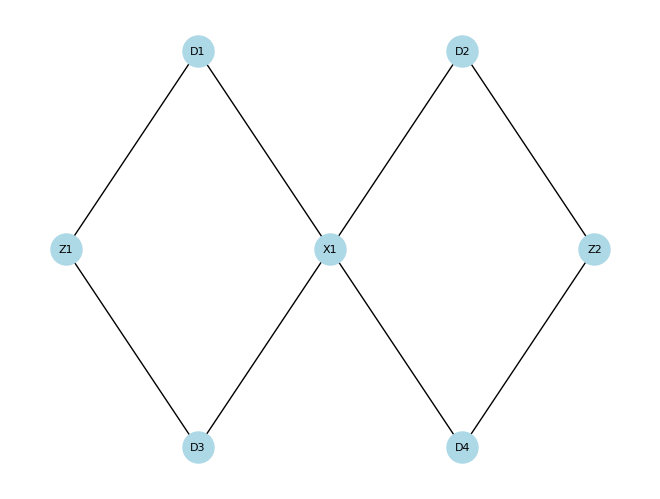

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a new graph
G = nx.Graph()

# Add nodes with positions
positions = {'D1': (0, 1), 'D2': (2, 1), 'D3': (0, -1), 'D4': (2, -1),
             'Z1': (-1, 0), 'X1': (1, 0), 'Z2': (3,0 )}

for node, pos in positions.items():
    G.add_node(node, pos=pos)

# Add edges between nodes
edges = [('D1', 'Z1'), ('D1', 'X1'), ('D2', 'X1'), ('D2', 'Z2'), 
         ('D3', 'Z1'), ('D3', 'X1'), ('D4', 'X1'), ('D4', 'Z2')]

G.add_edges_from(edges)

# Draw the graph
nx.draw(G, positions, with_labels=True, node_size=500, node_color='lightblue', font_size=8)
plt.show()


Let's try to build the circuit, using what we know from above and the Cleland paper. Qubit 4 will be the X ancilla, qubits 5 (z1) and 6 (z2) will be the z ancillas. The codewords are
$$
|0\rangle_L = \frac{1}{\sqrt{2}}(|0000\rangle + |1111\rangle), \quad |1\rangle_L = \frac{1}{\sqrt{2}}(|1010\rangle + |0101\rangle)
$$

and the stabilizers are
$$
X_1 X_2 X_3 X_4, \quad Z_1Z_3, \quad Z_2 Z_4
$$

So we can detect single phase flip errors from the $X$ stabilizer measurement $$X_1X_2X_3X_4\left(Z_\mu|\psi\rangle\right) = -Z_\mu\left(X_1X_2X_3X_4|\psi\rangle\right)\\
= -X_{1234}\left(Z_\mu|\psi\rangle\right)$$
and up to 2 bit flips (provided they are on qubits connected to different $Z$ stabilizers), e.g.
$$
Z_1Z_3\left(X_1 |\psi\rangle\right) = -Z_{13}\left(X_1 |\psi\rangle\right)
$$
and 
$$
Z_2Z_4\left(X_3 |\psi\rangle\right) = -Z_{24}\left(X_3|\psi\rangle\right)
$$

State:  [ 0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.5  0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.  -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0. ] 
 Result:  {'000': 511, '001': 489}


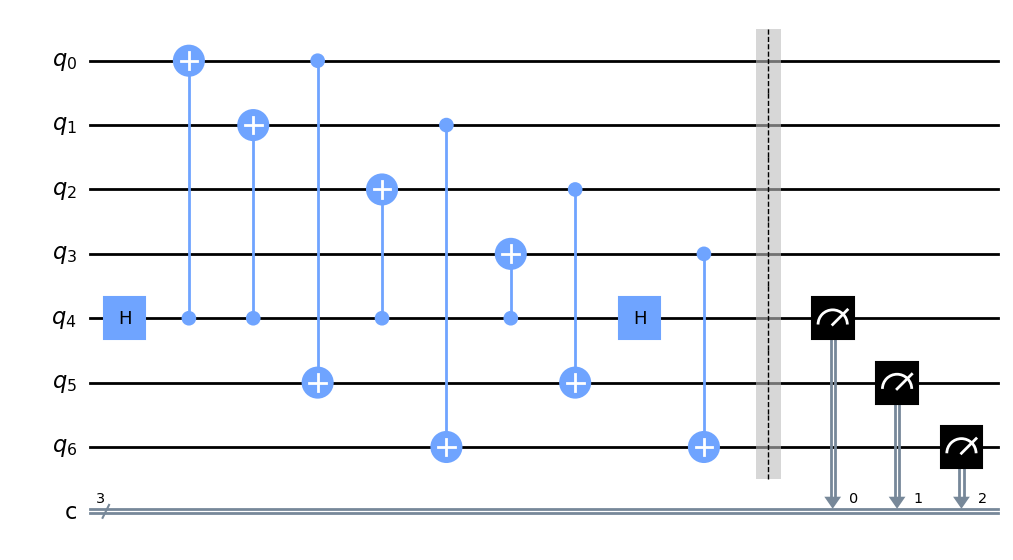

In [5]:
# Create a Quantum Register with 7 qubits (4 data qubits and 3 ancilla qubits for stabilizer + measurement)
qreg = QuantumRegister(7, 'q')

# Create a Classical Register
creg = ClassicalRegister(3, 'c')

# Create a Quantum Circuit for each cycle
sevenq_sc = QuantumCircuit(qreg, creg)

# Entangle with X ancilla (same as above)
sevenq_sc.h(qreg[4])

for i in range (0,4):
    sevenq_sc.cx(qreg[4], qreg[i]) #Remembering X type is control
    
sevenq_sc.h(qreg[4])

#Entangle with Z_1
sevenq_sc.cx(qreg[0], qreg[5])
sevenq_sc.cx(qreg[2], qreg[5])

#entangle with Z_2
sevenq_sc.cx(qreg[1], qreg[6])
sevenq_sc.cx(qreg[3], qreg[6])

sevenq_sc.barrier()

#Check the pre-measurement state
state_simulator = Aer.get_backend('statevector_simulator')
job = execute(sevenq_sc, state_simulator)
state_vector = job.result().get_statevector()

#Measure ancillas
for i in range(0, 3):
        sevenq_sc.measure(qreg[i+4], creg[i])

# Execute the circuit
job = execute(sevenq_sc, simulator, shots=1000)
result = job.result().get_counts()

print("State: ", np.asarray(state_vector).real, "\n Result: ", result)
sevenq_sc.draw('mpl')

We can see that we will be in our desired quiescent state when the ancillas are measured to all be $|000\rangle$ (which happens half the time). So let's now create a function to see how well the 7 qubit error detection surface code detects errors. Instead of running the circuit with all qubits starting in the $|0\rangle$ state, we'll just assume that the quiescent state is $|0\rangle_L$, as defined above. We currently just implement for Pauli errors.

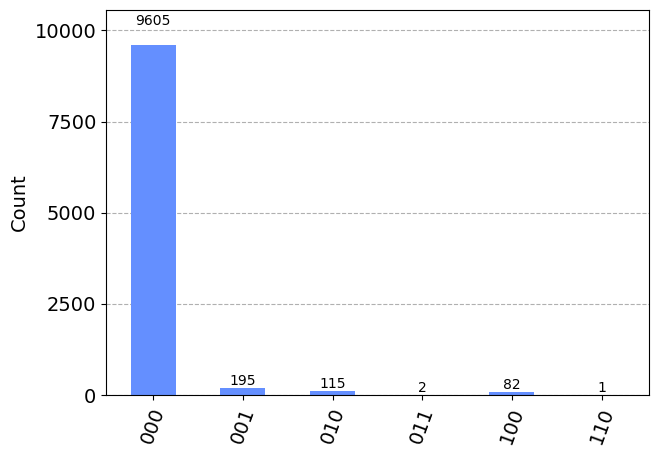

In [6]:
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import pauli_error

def simulate_surface7(num_cycles, p_pauli=0.0):
    """
    Simulates the 7-qubit surface code for a given number of cycles.

    Parameters:
    num_cycles (int): The number of error correction cycles to simulate.
    p_pauli (float, optional): The probability of a Pauli error (X or Z) occurring. Defaults to 0.0.

    The circuit performs the following steps for each cycle:
    - Applies Pauli errors based on the error model.
    - Resets ancilla qubits.
    - Entangles qubits to perform error correction.
    - Measures the state of ancilla qubits.
    
    Returns:
    dict: A dictionary of measurement outcomes with their corresponding counts.
    """
    
    # Initialize registers and circuit
    qreg = QuantumRegister(7, 'q')
    creg = ClassicalRegister(num_cycles * 3, 'c')
    circuit = QuantumCircuit(qreg, creg)

    # Define the state vector for the equal superposition of |0000> and |1111>
    state = [1/2**0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2**0.5]
    circuit.initialize(state, [0, 1, 2, 3])
    
    # Define Pauli error model
    error = pauli_error([('X', 0.5 * p_pauli), ('Z', 0.5 * p_pauli), ('I', 1.0 - p_pauli)])

    for cycle in range(num_cycles):
        
        # Append Pauli errors to each data qubit at the beginning of the cycle
        for i in range(4):
            circuit.append(error, [i])
            
        # Reset ancillas
        for i in range(4, 7):
            circuit.reset(qreg[i])

        # Entangle with X ancilla
        circuit.h(qreg[4])
        for i in range(4):
            circuit.cx(qreg[4], qreg[i])  # X type is control
        circuit.h(qreg[4])

        # Entangle with Z_1
        circuit.cx(qreg[0], qreg[5])
        circuit.cx(qreg[2], qreg[5])

        # Entangle with Z_2
        circuit.cx(qreg[1], qreg[6])
        circuit.cx(qreg[3], qreg[6])

        # Measure ancillas
        for i in range(3):
            circuit.measure(qreg[i + 4], creg[cycle * 3 + i])


        circuit.barrier()

    # Execute the circuit and get the result
    simulator = Aer.get_backend('aer_simulator')
    job = execute(circuit, simulator, shots=10000)
    result = job.result().get_counts()

    return result

# Example Usage
num_cycles = 1
p_pauli = 0.01 # Example probability for Pauli errors
result = simulate_surface7(num_cycles, p_pauli)

# Plot the histogram
plot_histogram(result)

Here we see the codes ability to detect errors. 

So we see the state will collapse to any one of the eigenstates of the stabilizers. Then, in the abscence of errors, this state will remain throughout all cycles, and the ancilla measurements will be the same. With the presence of errors, the error will causes a unique change in the ancilla readout/syndrome measurement.